In [1]:
import numpy as np
import networkx as nx

import matplotlib as mpl

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 30})
from QAOAKit import get_full_qaoa_dataset_table
import pandas as pd
pd.options.mode.chained_assignment = None 


First, filter out only the regular graphs

In [2]:
df = get_full_qaoa_dataset_table().reset_index()

# keep only regular graphs

df = df[df.apply(lambda row: nx.is_regular(row['G']), axis=1)]

# compute regularity

df['k'] = df.apply(lambda row: row['G'].degree[0], axis=1)

# separate even and odd graphs

df_even_only=df[df.apply(lambda row: row['k']%2==0, axis=1)]

df_odd_only=df[df.apply(lambda row: row['k']%2==1, axis=1)]

Check what we got:

In [3]:
for degree in set(df['k']):
    print(f"Found {len(df[df['k'] == degree])} {degree}-regular graphs")
print('even-degree regular graphs:',len(df_even_only))
print('odd-degree regular graphs:',len(df_odd_only))

Found 21 2-regular graphs
Found 24 3-regular graphs
Found 78 4-regular graphs
Found 12 5-regular graphs
Found 18 6-regular graphs
Found 3 7-regular graphs
Found 3 8-regular graphs
even-degree regular graphs: 120
odd-degree regular graphs: 39


### Computing symmetries and plotting

Define a simple function that generates the symmetrical angles

In [4]:
def generate_symmetric_angles(gamma,beta,symmetry):
    
    #assumes p=1
    
    if symmetry == 'even':
        #even symmetry angles, time reversal, even + time reversal
        return np.array(gamma)+1.0, np.array(beta),-np.array(gamma), -np.array(beta),-np.array(gamma)-1.0, -np.array(beta)
    elif symmetry == 'odd':
        #even symmetry angles, time reversal, odd + time reversal
        return np.array(gamma)+1.0, -np.array(beta),-np.array(gamma), -np.array(beta),-np.array(gamma)-1.0, np.array(beta)
    else:
        raise ValueError(f"Unknown symmetry: {symmetry}")

Apply it on all graphs in the dataframe:

In [5]:

df_even_only[['gamma even', 'beta even','gamma time reversed', 'beta time reversed',
    'gamma even+time reversed', 'beta even+time reversed']] = df_even_only.apply(
    lambda row: generate_symmetric_angles(row['gamma'],row['beta'],'even'),
    axis = 1,
    result_type="expand",
)
df_odd_only[['gamma odd', 'beta odd','gamma time reversed', 'beta time reversed',
    'gamma odd+time reversed', 'beta odd+time reversed']] = df_odd_only.apply(
    lambda row: generate_symmetric_angles(row['gamma'],row['beta'],'odd'),
    axis = 1,
    result_type="expand",
)

Now plot the angles for `p=1`

In [6]:
# stack beta and gamma together into one vector

df_even_only['theta'] = df_even_only.apply(lambda row: np.hstack([row['beta'], row['gamma']]), axis=1)
df_even_only['theta even'] = df_even_only.apply(lambda row: np.hstack([row['beta even'], row['gamma even']]), axis=1)
df_even_only['theta time reversed'] = df_even_only.apply(lambda row: np.hstack([row['beta time reversed'], row['gamma time reversed']]), axis=1)
df_even_only['theta even+time reversed'] = df_even_only.apply(lambda row: np.hstack([row['beta even+time reversed'], row['gamma even+time reversed']]), axis=1)


df_odd_only['theta'] = df_odd_only.apply(lambda row: np.hstack([row['beta'], row['gamma']]), axis=1)
df_odd_only['theta odd'] = df_odd_only.apply(lambda row: np.hstack([row['beta odd'], row['gamma odd']]), axis=1)
df_odd_only['theta time reversed'] = df_odd_only.apply(lambda row: np.hstack([row['beta time reversed'], row['gamma time reversed']]), axis=1)
df_odd_only['theta odd+time reversed'] = df_odd_only.apply(lambda row: np.hstack([row['beta odd+time reversed'], row['gamma odd+time reversed']]), axis=1)


In [7]:
# get the angles into numpy format

#original data for even-degree k-regular
data_even = df_even_only[df_even_only['p_max'] == 1]['theta'].values

#even-degree symmetry on even data
data_even_even_sym = df_even_only[df_even_only['p_max'] == 1]['theta even'].values

#time-reversal symmetry on even data
data_even_time_reversed = df_even_only[df_even_only['p_max'] == 1]['theta time reversed'].values

#time-reversal + even symmetry on even data
data_even_time_reversed_even_sym = df_even_only[df_even_only['p_max'] == 1]['theta even+time reversed'].values

#same for the odds
data_odd = df_odd_only[df_odd_only['p_max'] == 1]['theta'].values
data_odd_odd_sym = df_odd_only[df_odd_only['p_max'] == 1]['theta odd'].values
data_odd_time_reversed = df_odd_only[df_odd_only['p_max'] == 1]['theta time reversed'].values
data_odd_time_reversed_odd_sym = df_odd_only[df_odd_only['p_max'] == 1]['theta odd+time reversed'].values


Plot the datasets with varying symmetries.  Colors are added in the background to emphasize the symmetry-related regions in parameter space.

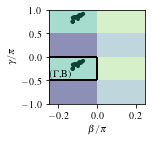

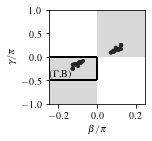

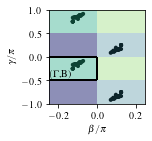

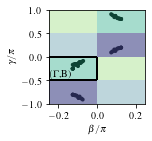

In [8]:
import seaborn as sns

def generate_plot(dataset,Symmetry1,Symmetry2):
    #make a plot with the given symmetries indicated in color
    #Symmetry1 = 'even', 'odd', or 'time-reversal'
    #Symmetry2 = '' for a single symmetry only, 'time-reversal' for two symmetries
    fig, ax = plt.subplots(figsize=(6.92654/4, 6.92654/4))
    palette = sns.color_palette("viridis",4)
    if dataset=='even':
        to_plot = np.stack(data_even)
    elif dataset=='odd':
        to_plot = np.stack(data_odd)
    ax.scatter(to_plot[:,0], to_plot[:,1], s=16, edgecolors='None',color='k')
    
    # color boxes and data for even symmetry
    
    if Symmetry1 == 'even':
        to_plot = np.stack(data_even_even_sym)
        ax.scatter(to_plot[:,0],to_plot[:,1],s=16,edgecolors='None',color='k')
        ax.axhspan(ymin=-1, ymax=-0.5, xmin=0,xmax=0.5,facecolor=palette[0], alpha=0.6)
        ax.axhspan(ymin=-0.5, ymax=0, xmin=0,xmax=0.5,facecolor=palette[2], alpha=0.4)
        ax.axhspan(ymin=0, ymax=0.5, xmin=0,xmax=0.5,facecolor=palette[0], alpha=0.6)
        ax.axhspan(ymin=0.5, ymax=1, xmin=0,xmax=0.5,facecolor=palette[2], alpha=0.4)
        ax.axhspan(ymin=-1, ymax=-0.5, xmin=0.5,xmax=1.0,facecolor=palette[1], alpha=0.3)
        ax.axhspan(ymin=-0.5, ymax=0, xmin=0.5,xmax=1.0,facecolor=palette[3], alpha=0.3)
        ax.axhspan(ymin=0, ymax=0.5, xmin=0.5,xmax=1.0,facecolor=palette[1], alpha=0.3)
        ax.axhspan(ymin=0.5, ymax=1, xmin=0.5,xmax=1.0,facecolor=palette[3], alpha=0.3)
        
    # color boxes and data for odd symmetry
    
    if Symmetry1 == 'odd':
        to_plot = np.stack(data_odd_odd_sym)
        ax.scatter(to_plot[:,0],to_plot[:,1],s=16,edgecolors='None',color='k')
        ax.axhspan(ymin=-1, ymax=-0.5, xmin=0,xmax=0.5,facecolor=palette[0], alpha=0.6)
        ax.axhspan(ymin=-0.5, ymax=0, xmin=0,xmax=0.5,facecolor=palette[2], alpha=0.4)
        ax.axhspan(ymin=0, ymax=0.5, xmin=0,xmax=0.5,facecolor=palette[1], alpha=0.3)
        ax.axhspan(ymin=0.5, ymax=1, xmin=0,xmax=0.5,facecolor=palette[3], alpha=0.3)
        ax.axhspan(ymin=-1, ymax=-0.5, xmin=0.5,xmax=1.0,facecolor=palette[1], alpha=0.3)
        ax.axhspan(ymin=-0.5, ymax=0, xmin=0.5,xmax=1.0,facecolor=palette[3], alpha=0.3)
        ax.axhspan(ymin=0, ymax=0.5, xmin=0.5,xmax=1.0,facecolor=palette[0], alpha=0.6)
        ax.axhspan(ymin=0.5, ymax=1, xmin=0.5,xmax=1.0,facecolor=palette[2], alpha=0.4)
    
    # color boxes and data for odd symmetry
    
    if Symmetry1 == 'time-reversal':
        #assumes we have are using the data even dataset
        if dataset=='even':
            to_plot = np.stack(data_even_time_reversed)
        elif dataset=='odd':
            to_plot = np.stack(data_odd_time_reversed)
        ax.scatter(to_plot[:,0],to_plot[:,1],s=16,edgecolors='None',color='k')
        ax.axhspan(ymin=-1, ymax=0, xmin=0,xmax=0.5,facecolor='gray', alpha=0.3)
        ax.axhspan(ymin=0, ymax=1, xmin=0.5,xmax=1,facecolor='gray', alpha=0.3)
        
    # add data for time-reversal if the first symmetry is even or odd
    
    if Symmetry2=='time-reversal':
        if Symmetry1=='even':
            to_plot = np.stack(np.hstack([data_even_time_reversed,data_even_time_reversed_even_sym]))
        elif Symmetry1=='odd':
            to_plot = np.stack(np.hstack([data_odd_time_reversed,data_odd_time_reversed_odd_sym]))
        ax.scatter(to_plot[:,0],to_plot[:,1],s=16,edgecolors='None',color='k')            
        
    #label [Gamma,Beta] parameter space
    
    plt.arrow(-0.25,-0.5,0.25,0,head_length=0,lw=2)
    plt.arrow(-0.25,0.0,0.25,0,head_length=0,lw=2)
    plt.arrow(0,-0.5,0,0.5,head_length=0,lw=2)
    plt.arrow(-0.25,-0.50,0,0.5,head_length=0,lw=2)
    ax.text(-0.25, -0.425, '$(\Gamma$,B)') #  ,fontsize=15
    
    #axis labels and limits
    
    plt.xlabel('$\\beta/\\pi$')
    plt.ylabel('$\\gamma/\\pi$')
    plt.xlim(-0.25,0.25)
    plt.ylim(-1,1)
    plt.savefig('p=1_'+Symmetry1+Symmetry2+'.pdf',bbox_inches='tight')

for symmetry1, symmetry2 in [
    ('even', ''),
    ('time-reversal', ''),
    ('even', 'time-reversal'),
    ('odd', 'time-reversal'),
]:
    generate_plot('even', symmetry1, symmetry2)

